[-98.17086885   1.44984922]


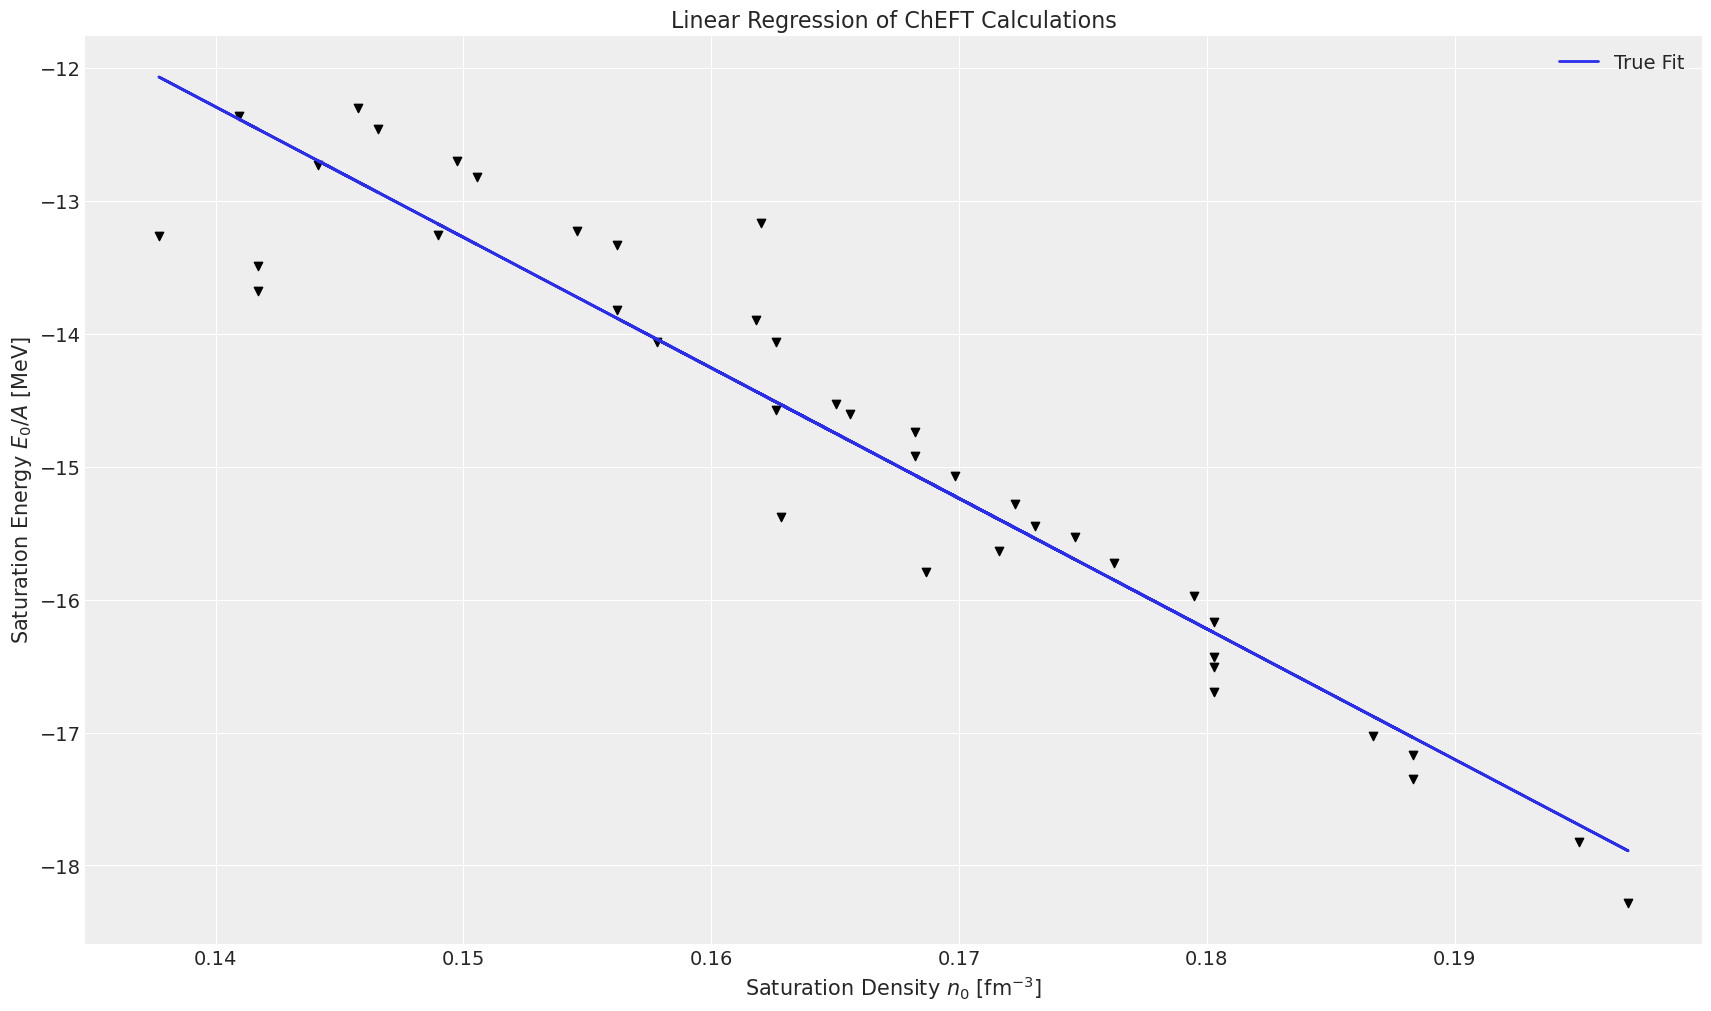

In [17]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

dtypes = {"hamiltonian": str, "hamiltonian_brief": str, "n0": np.float64, "En0": np.float64, "method": str, \
          "mbpt_order": np.float64,"set_id": str, "reference": str}
mytypes = {"n0": np.float64, "En0": np.float64}
dt = pd.read_csv("data/saturation_points.csv", comment = "#", usecols=[2,3])

x = dt["n0"]
y = dt["En0"]
                 

reg = np.polyfit(x, y, 1)  #TODO: not sure if 1/y is correct weights value
print(reg)

plt.figure(figsize=(17,10))
plt.scatter(x, y, c='black', marker='v')
plt.title(label='Linear Regression of ChEFT Calculations')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0, label="True Fit")
plt.grid(True)
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
plt.ylabel('Saturation Energy $E_0/A$ [MeV]')
plt.legend()
plt.legend(loc='upper right')
plt.show()

C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


C:\Users\sbezo\AppData\Local\Temp\ipykernel_17688\1947705241.py:10: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(1000, step, start=start, progressbar=False)
C:\Users\sbezo\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, $β_1$, $β_0$]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\sbezo\AppData\Local\Temp\ipykernel_17688\1947705241.py:12: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from Arv

{'$β_0$': 2.3222572001409043, '$β_1$': -103.6358713845845, '$\\sigma$_log__': -0.48065928910796984, '$\\sigma$': 0.6183755691070343}


C:\Users\sbezo\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:214: UserWarning: A valid var_name should be provided, found {'b', 's'} expected from {'$\\sigma$', '$β_1$', '$β_0$'}
  warnings.warn(


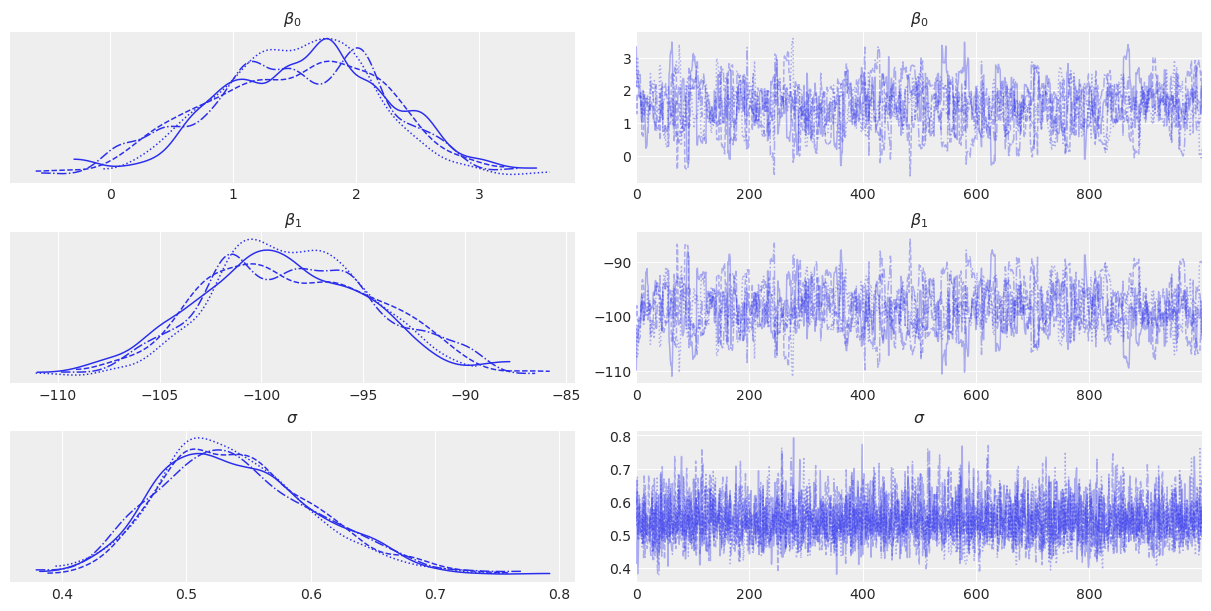

<Figure size 800x1000 with 0 Axes>

In [16]:
 with pm.Model() as model:
        
    beta_0 = pm.Normal('$β_0$', mu=1.5, sd=1)
    beta_1 = pm.Normal('$β_1$', mu=-100, sd=50)
    sigma = pm.InverseGamma('$\sigma$', alpha=6, beta=5) #mean = 1 varience = .5^2
    y_est =  beta_0 + beta_1 * x
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(1000, step, start=start, progressbar=False)
    print(trace[0])
    fig = pm.traceplot(trace, lines={'beta_0': 4, 'beta_1': 2, 'sigma': 2})
    plt.figure(figsize=(8, 10))
    plt.show()

In [18]:
 pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\sbezo\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$β_0$,1.521,0.687,0.185,2.721,0.029,0.022,544.0,638.0,1.01
$β_1$,-98.603,4.138,-105.851,-90.618,0.177,0.125,546.0,710.0,1.01
$\sigma$,0.542,0.063,0.426,0.656,0.001,0.001,3599.0,2263.0,1.00


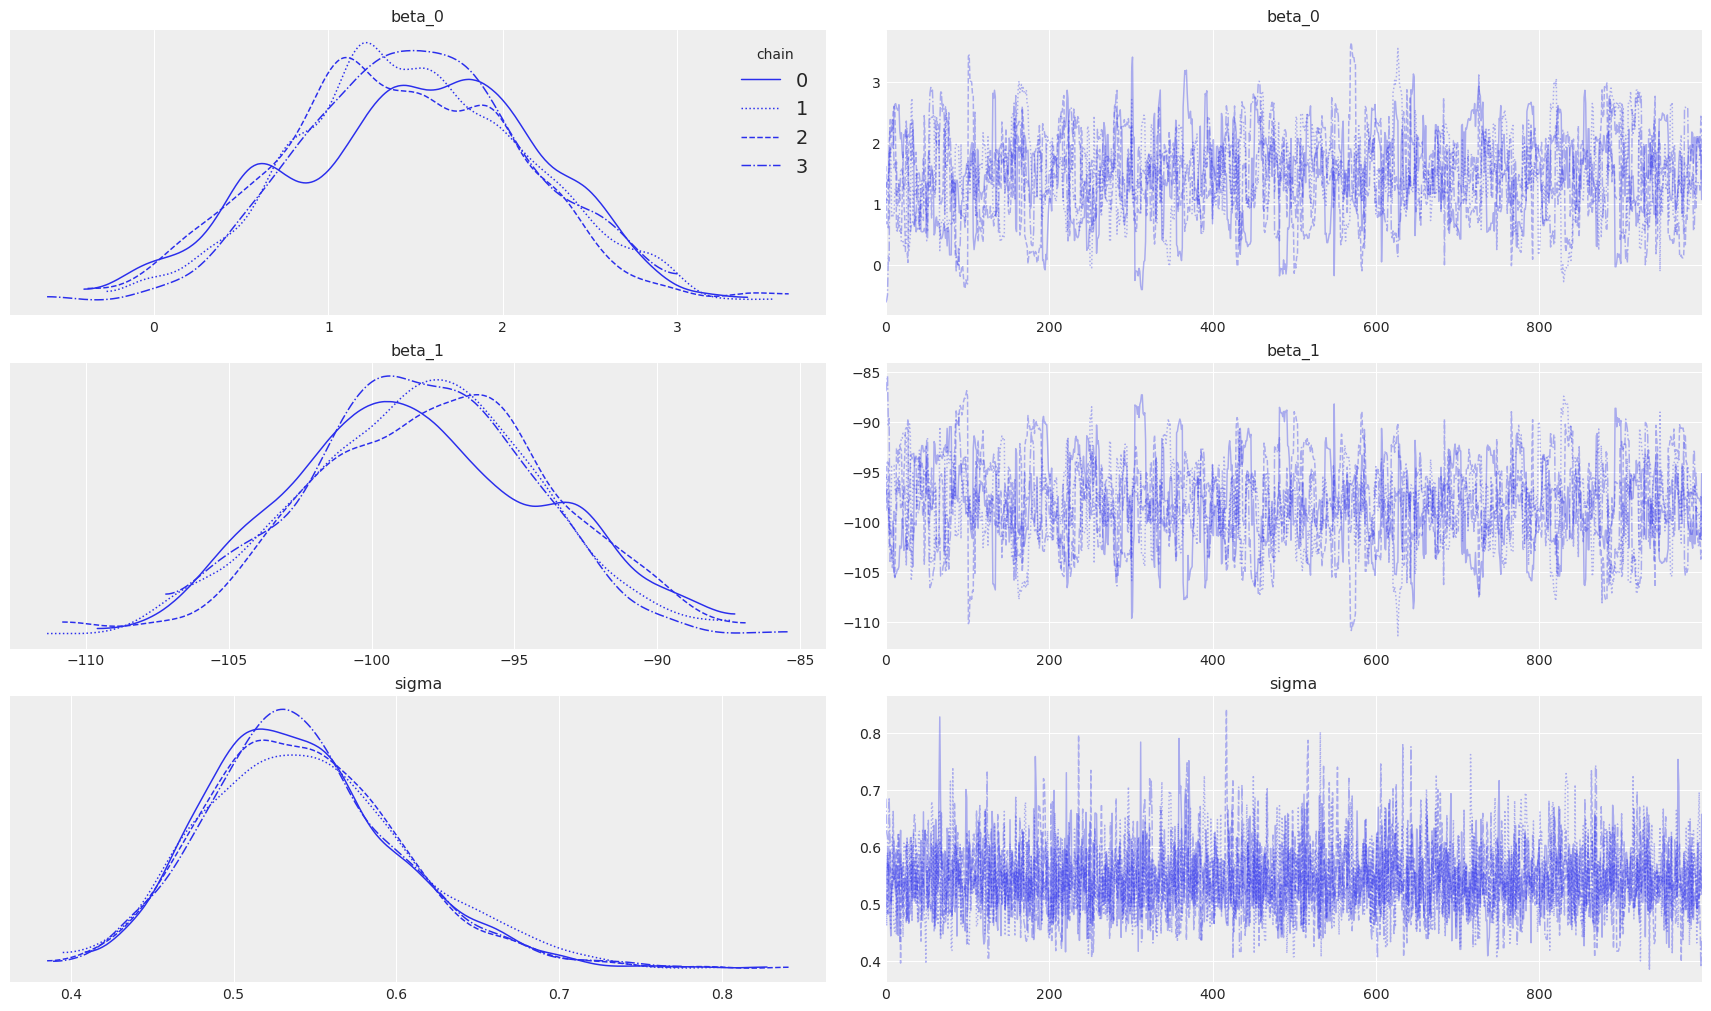

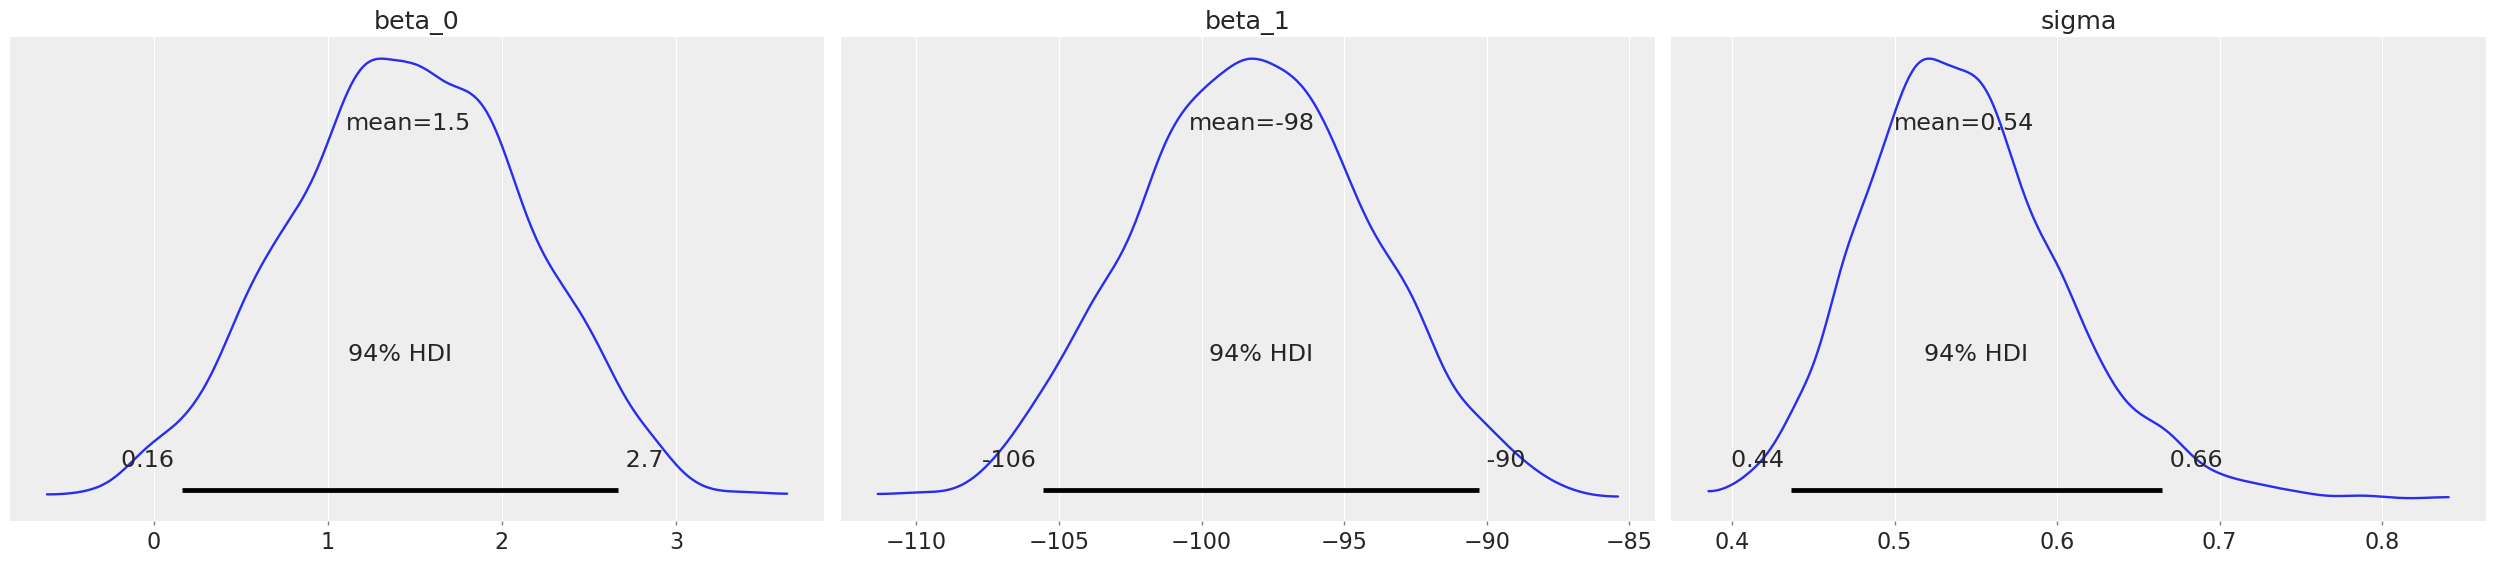

In [7]:
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42, progressbar=True)


with model: 
    trace_updated = az.from_pymc3(trace, posterior_predictive=ppc)
    
az.style.use("arviz-darkgrid")
with model:
  az.plot_trace(trace_updated, figsize=(17,10), legend=True)


az.style.use("arviz-darkgrid")
with model:
  az.plot_posterior(trace_updated,textsize=16)

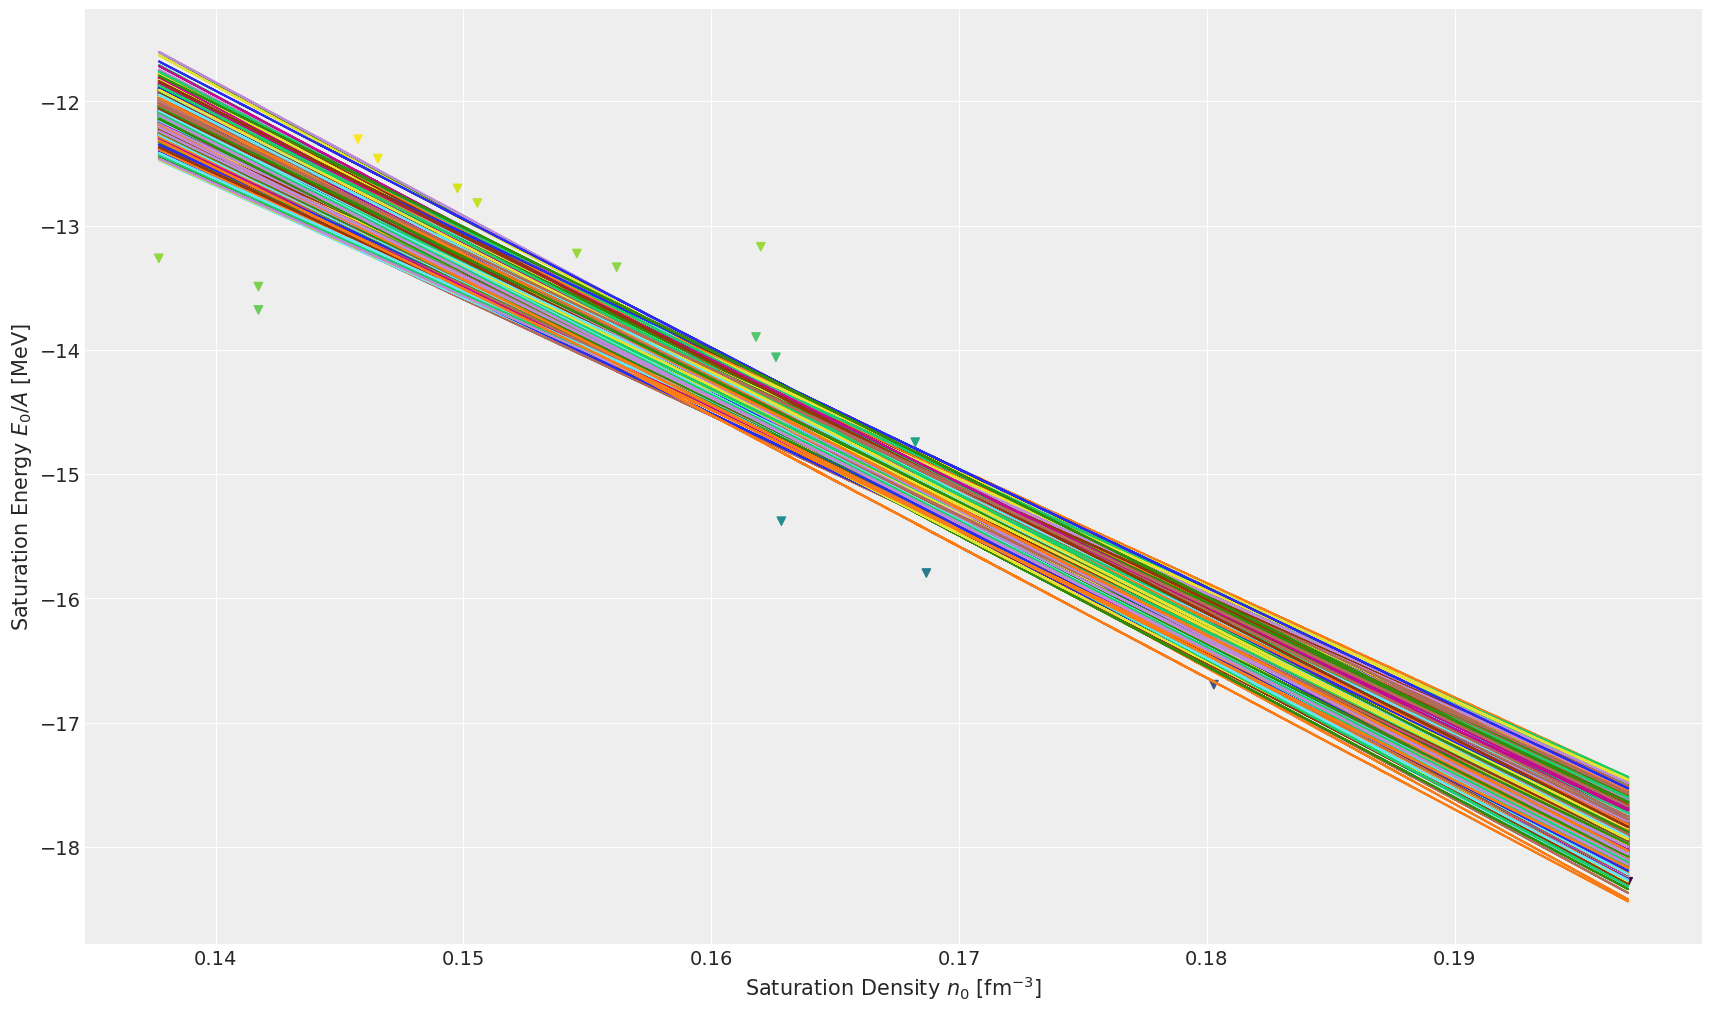

In [9]:
plt.figure(figsize=(17,10))
plt.scatter(x, y, c=y, marker='v')
plt.grid(True)
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
plt.ylabel('Saturation Energy $E_0/A$ [MeV]')

for i in range(len(trace)): 
    plt.plot(x, trace['beta_0'][i] + trace['beta_1'][i] * x) #TODO: Add uncertainity band, add credibility level, make color code meaningful
    
plt.show()



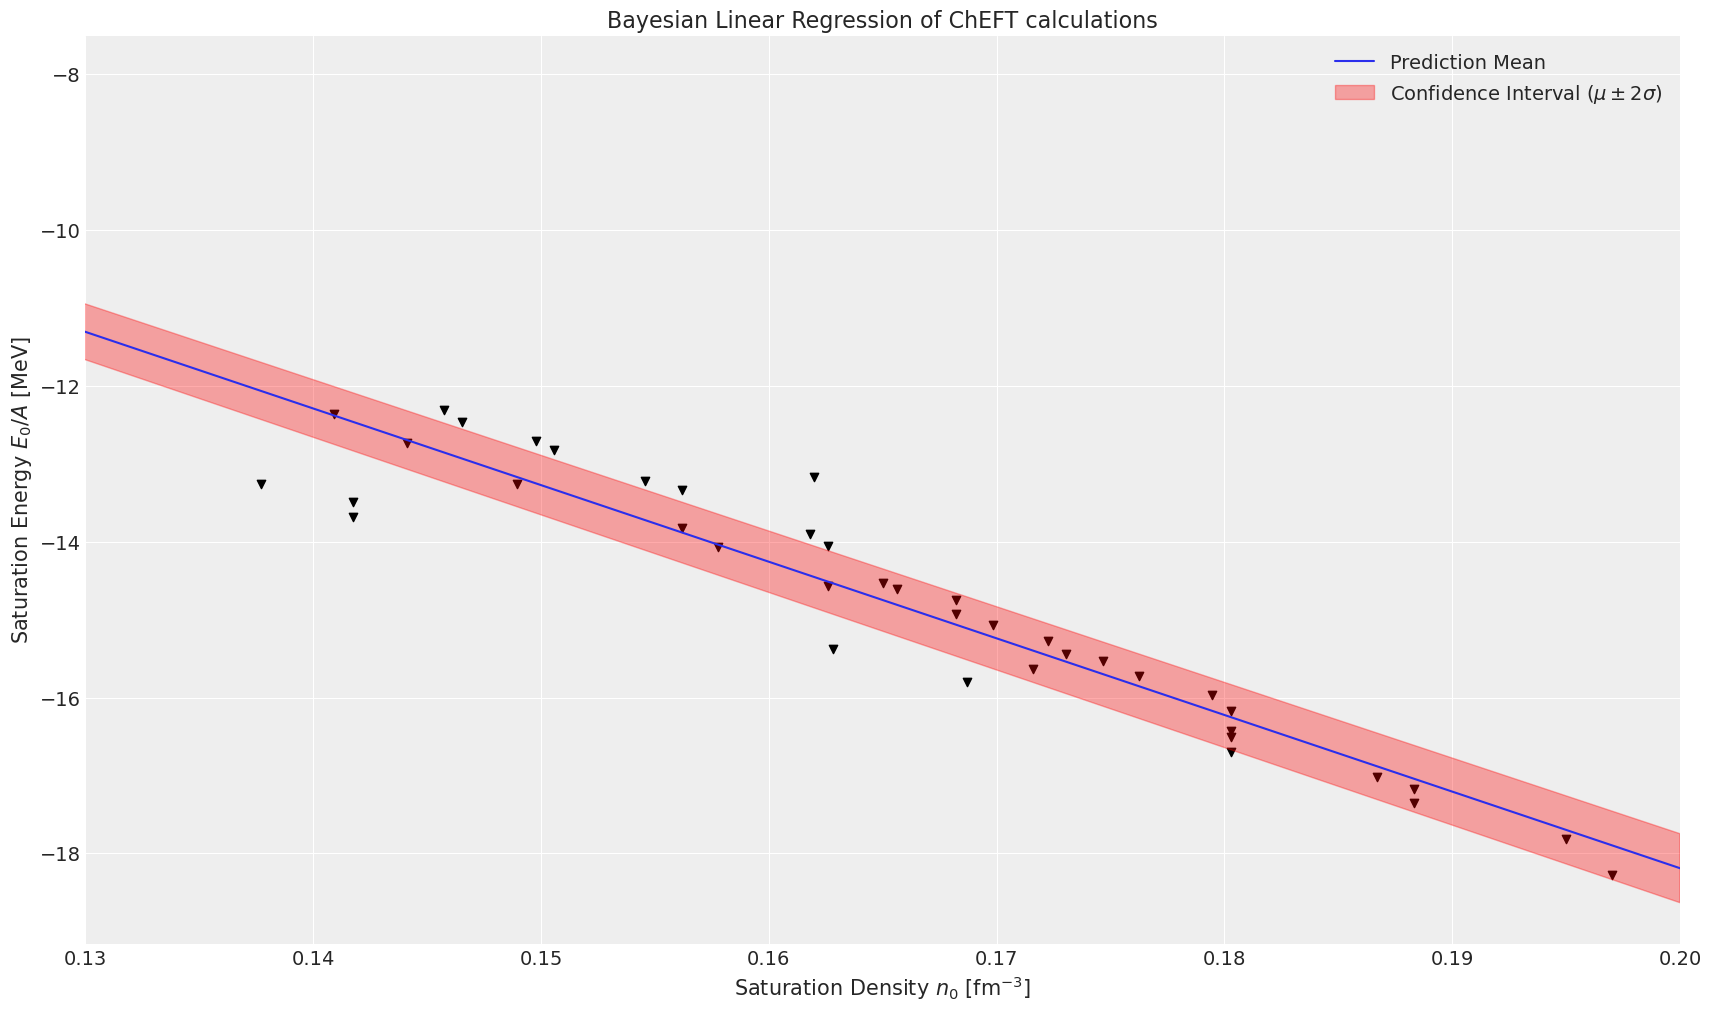

In [11]:
Z_0 = 1.96
beta_0_mean = 1.480
beta_0_std = 0.646
beta_1_mean = -98.355
beta_1_std = 3.914

x_new = np.linspace(0.1, 0.2, 100)
y_average = beta_0_mean + beta_1_mean * x_new

def confidence_interval(mean, std, Z, number_of_samples):
    upper = mean + Z * (std / (number_of_samples)**(1/2))
    lower = mean - Z * (std / (number_of_samples)**(1/2))
    return lower,upper

beta_0_ci = confidence_interval(beta_0_mean, beta_0_std, Z_0, 40)
beta_1_ci = confidence_interval(beta_1_mean, beta_1_std, Z_0, 40)
    
y_min = beta_0_ci[0] + beta_1_ci[0] * x_new

y_max = beta_0_ci[1] + beta_1_ci[1] * x_new

#plt.plot(x, y_min)
#plt.plot(x, y_max)
plt.figure(figsize=(17,10))
plt.xlim([.13,.2])
plt.scatter(x, y, c='black', marker='v')
plt.grid(True)
plt.title(label = 'Bayesian Linear Regression of ChEFT calculations')
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
plt.ylabel('Saturation Energy $E_0/A$ [MeV]')
plt.plot(x_new, y_average, label='Prediction Mean')
plt.legend()
#plt.fill_between(x, y_average - 1.96 * np.std(y)/(40)**(1/2), y_average + 1.96 * np.std(y)/(40)**(1/2), color='b')
plt.fill_between(x_new, y_min , y_max , color='r', alpha=.33, label= 'Confidence Interval ($\mu\pm2\sigma$)')
plt.legend(loc='upper right')
plt.savefig("BayesianLinRegChEFT.pdf")

In [13]:
print('$\sigma$')

$\sigma$
